In [1]:
import numpy as np

from neurodsp.sim import sim_synaptic_current
from neurodsp.utils.data import compute_nsamples
from neurodsp.plts import plot_time_series
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf

def exp_decay_func(delta_t, amplitude, tau, offset):
    return amplitude * (np.exp(-(delta_t / tau)) + offset)

In [2]:
taus = np.linspace(.001, .01, 10) #taus = np.arange(0.005,0.08,0.01)

fs = 2000
n_seconds = 10

n_lags = 100
n_sims = 100

n_samples = compute_nsamples(n_seconds, fs)

sigs = np.zeros((len(taus), n_samples))
acfs = np.zeros((len(taus), n_lags+1))
taus_hat =  np.zeros((len(taus)))

for ind, tau in enumerate(taus):
    
    _sig = np.zeros((n_sims, n_samples))
    
    for n in range(n_sims):
        
        _sig[n] = sim_synaptic_current(n_seconds, fs, tau_d=tau)
    
    sig = np.mean(_sig, axis=0)
    sigs[ind] = sig
    
    acfs[ind] = acf(sig, nlags=n_lags, qstat=False, fft=True)

    params, _ = curve_fit(exp_decay_func, np.arange(0, len(acfs[ind])), acfs[ind], maxfev=10000)

    taus_hat[ind] = params[1]

Text(0.5, 0, 'Simulated Tau (tau_d sim_synaptic_current)')

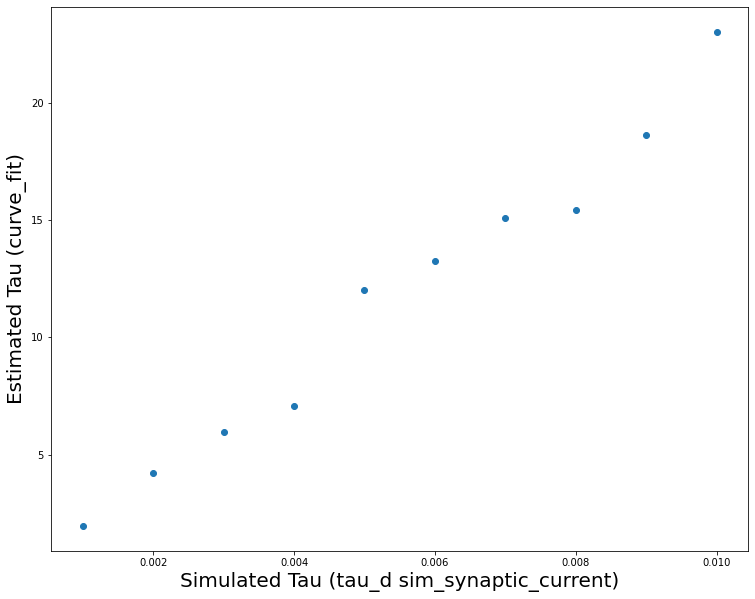

In [3]:
fig = plt.figure(figsize=(12.5, 10))

plt.scatter(taus, taus_hat)

plt.ylabel('Estimated Tau (curve_fit)', size=20)
plt.xlabel('Simulated Tau (tau_d sim_synaptic_current)', size=20)

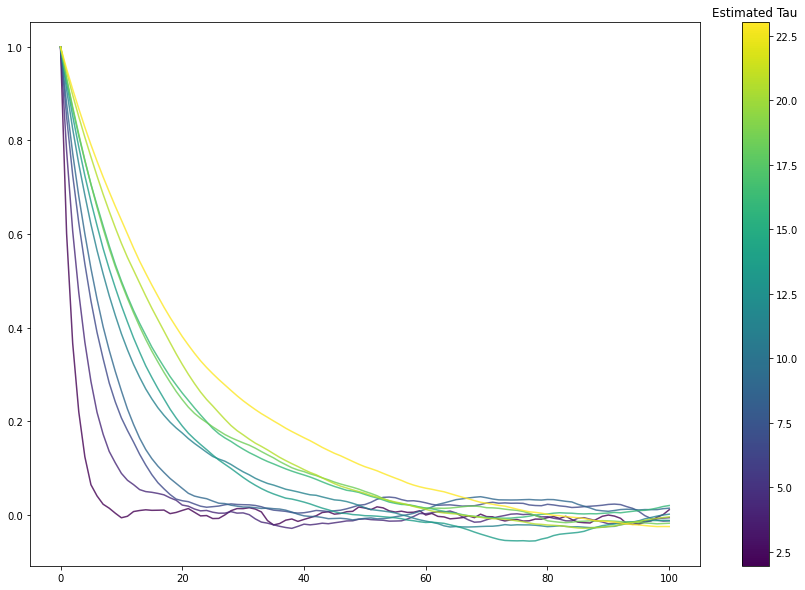

In [4]:
fig = plt.figure(figsize=(15, 10))

norm=plt.Normalize(vmin=taus_hat.min(), vmax=taus_hat.max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar = plt.colorbar(sm)
cbar.ax.set_title("Estimated Tau")
cmap = plt.get_cmap('viridis', len(acfs))

for n in range(len(acfs)):
    plt.plot(acfs[n][:501], color=cmap(n), alpha=.8)

### Simulate Timescales

In [5]:
def sim_timescale(sig, n_neurons=100):
    
    # Convert signal from probabilities from 0-1
    probs = (sig - np.min(sig)) / np.ptp(sig)

    neurons = np.zeros((n_neurons, len(probs)))

    for ind, prob in enumerate(probs):

        prob_fire = np.zeros(1000)
        prob_fire[:int(prob * 1000)] = 1
        neurons[:, ind] = np.random.choice(prob_fire, n_neurons)
    
    timescale = neurons.sum(axis=0)
    
    return timescale, neurons

<Figure size 432x288 with 0 Axes>

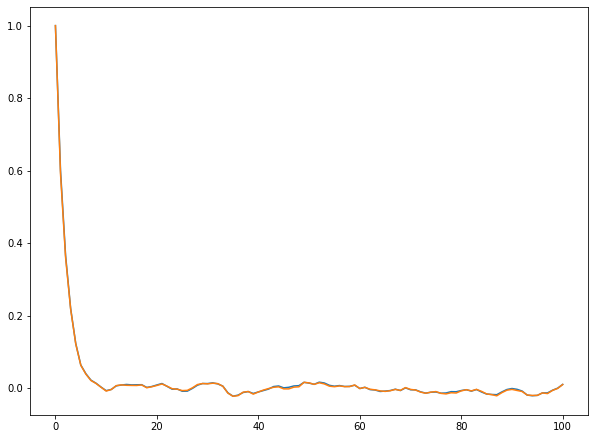

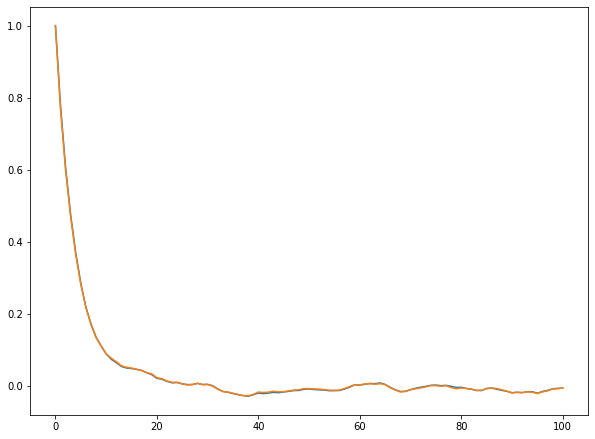

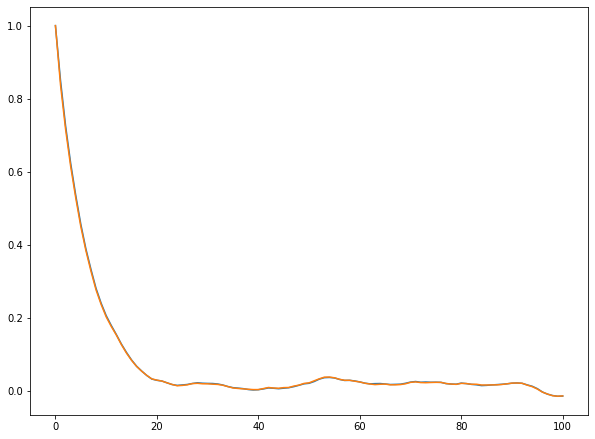

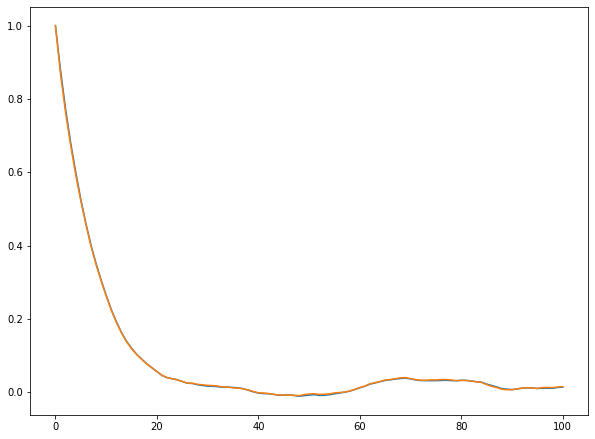

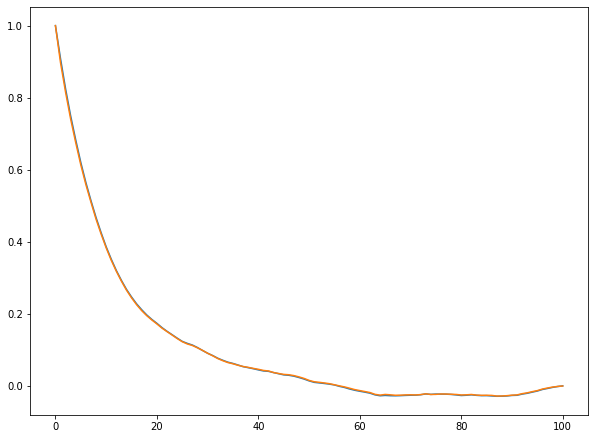

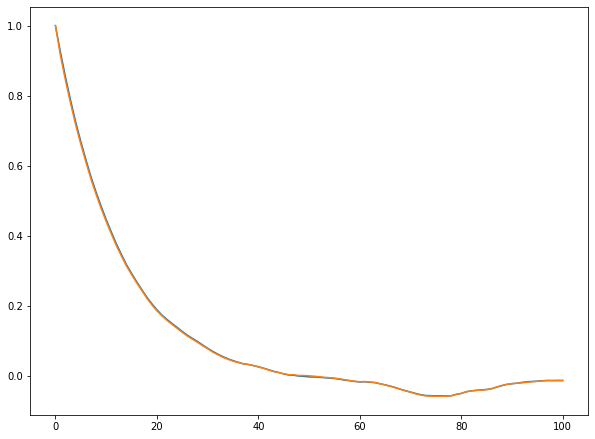

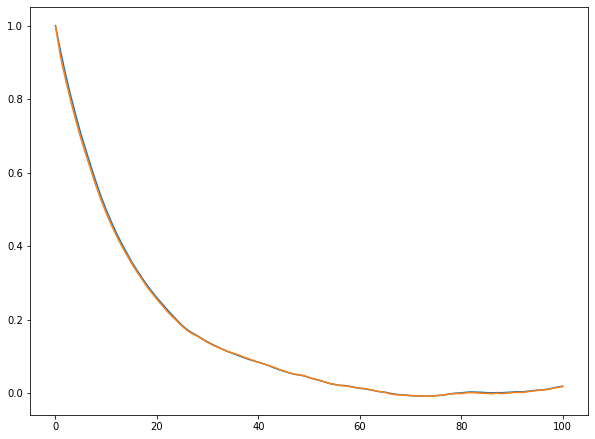

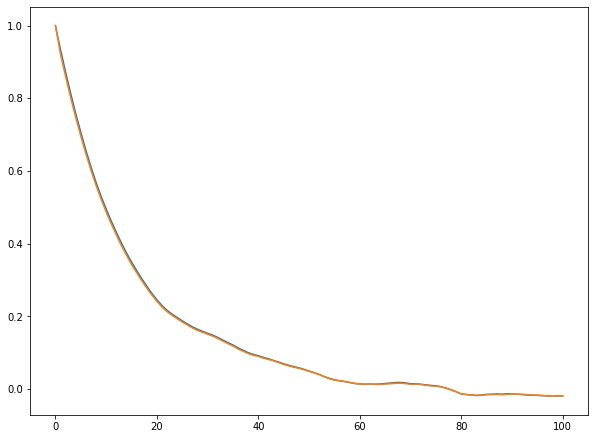

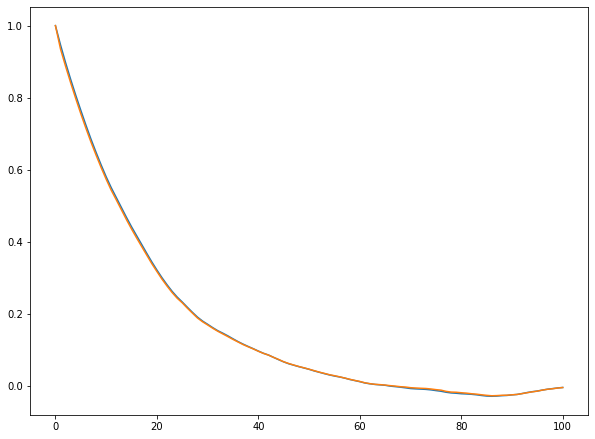

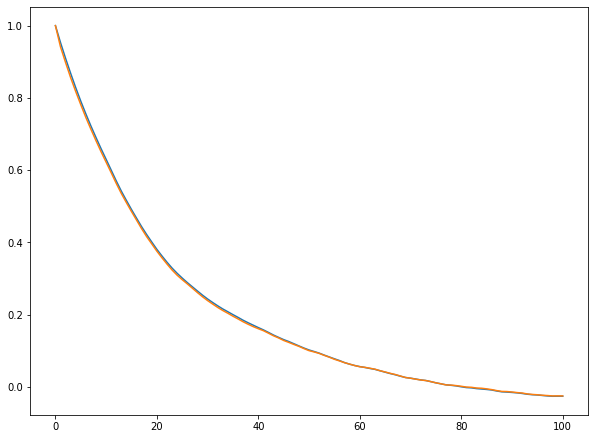

In [6]:
for ind, sig in enumerate(sigs):
    
    timescale, neurons = sim_timescale(sig, n_neurons=1000)

    # Plot
    plt.figure(ind)
    
    plt.figure(figsize=(10, 7.5))

    plt.plot(acf(sig, nlags=100, fft=True))

    plt.plot(acf(timescale, nlags=100, fft=True))